# Кластеризация
В задаче классификации мы имели дело с восстановлением отображения из множества объектов в конечный набор меток классов. При этом классы были зафиксированы заранее, то есть мы с самого начала примерно понимали, какого рода объекты должны относиться к каждому из них, и мы располагали обучающей выборкой с примерами объектов и классов, к которым они относятся. 

Существуют также задачи, когда мы имеем данные, но целевая переменная (target variable) нам не задана, т.е. принадлежность объектов к каким-либо классам не дана. В таком случае мы решаем задачу **кластеризации**, которая относится к разделу **обучения без учителя (unsupervised learning)**. В задаче кластеризации мы тоже разбиваем объекты на конечное множество классов, но у нас нет ни обучающей выборки, ни понимания, какой будет природа этих классов. То, что модель кластеризации какие-то объекты сочла «похожими», отнеся к одному классу, будет новой информацией, «открытием», сделанным этой моделью. Обучающей выборки у нас также не будет: ведь мы не знаем заранее, что за классы получатся (а иногда и сколько их будет).

Задачей является построение алгоритма, который позволит разделить исходные данные на *кластеры*, т.е. объекты с похожими свойствами.

Зачем это нужно? Цели могут быть разными:
- Сделать дальнейшую работу с данными удобнее и проще; работать с каждым кластером в отдельности
- Задача сжатия данных (оставлять только типичного представителя из каждого кластера)
- Построить иерархию множества (задача таксономии: крупные кластеры делятся на более мелкие, те в свою очередь также дробятся и т.д.)
- Нахождение объектов, не относящихся ни к одному из кластеров
- Разбить объекты на кластеры и использовать эту новую информацию при решении задачи классификации/регрессии

In [1]:
# Сгенерируем данные
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16}) # Для изменения размера шрифта на графиках
import numpy as np


X, y_true = make_blobs(n_samples=800, centers=10,
                       cluster_std=1.00, random_state=0)
X = X[:, ::-1]

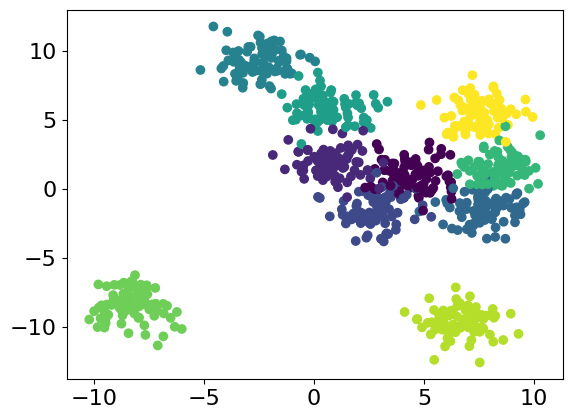

In [2]:
plt.scatter(X[:, 0], X[:, 1], c=y_true)

**Метод k-средних** (**k-means**)

Существуют разные алгоритмы кластеризации, рассмотрим один из самых популярных, а именно **метод k-средних** (**k-means**). Алгоритм выглядит следующим образом:
1) Задаются начальные координаты центров кластеров. В самом простом случае - случайным образом.
2) Для каждого $x_i$ вычисляются расстояния до центров кластеров. Относим $x_i$ к ближайшему кластеру.
3) Вычисляются новые координаты центров: для каждого кластера считаем среднее значение по всем объектам, которые принадлежат данному кластеру. 
4) Повторяем шаги 2-3 до выполнения какого-либо условия (кол-во итераций, желаемая точность и т.д.)


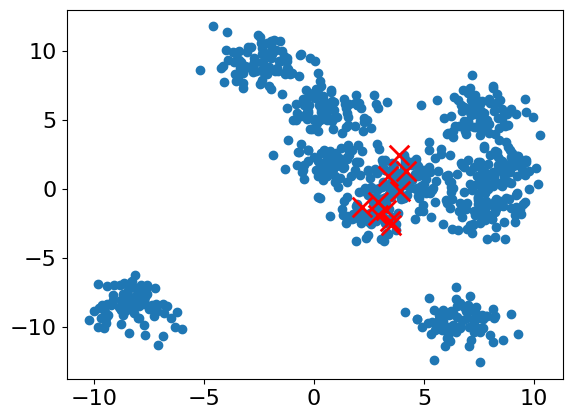

In [3]:
num_clust = 10
# Зададим начальные центры кластеров (центроиды)
centers = np.zeros((num_clust, 2))

mu_data = np.mean(X, axis=0)
# x0_min, x0_max = (min(X[:, 0])), (max(X[:, 0]))
# x1_min, x1_max = (min(X[:, 1])), (max(X[:, 1]))
for ii in range(num_clust):
    centers[ii, 0] = mu_data[0] + np.random.randn()*1.5
    centers[ii, 1] = mu_data[1] + np.random.randn()*1.5

plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centers[:, 0], centers[:, 1], marker='x', lw=2, color='r', s=200)

In [4]:
def euclid_dist(x0, x1):
    return np.sqrt(((x0-x1)**2).sum())

num_iter = 50
iteration = 0
while iteration < num_iter:
    y_pred = []
    for obj in X:
        # Для каждого объекта считаем расстояние до центроида
        dists = list(map(lambda y: euclid_dist(obj, y), centers))
        # Относим каждый X к ближайшему центру
        y_pred.append(np.argmin(dists))

    y_pred = np.array(y_pred)
    # Обновляем координаты центров, вычисляя среднее значение по всем X,
    # принадлежащим к каждому из кластеров
    for ii in range(num_clust):
        centers[ii, :] = np.mean(X[y_pred==ii, :], axis=0)
        
    iteration += 1

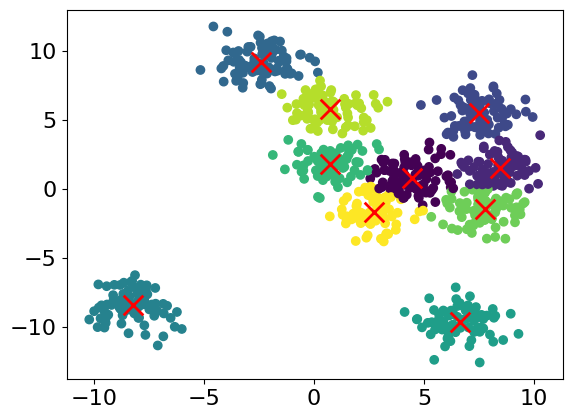

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', lw=2, color='r', s=200)

**Выбор начального приближения**

*Первая возможная проблема*: если выбирать центры кластеров из случайного распределения, то есть возможность попадания в область пространства признаков, в которой нет точек выборки. Чтобы этого избежать, можно, например, выбрать в качестве начальных центров какие-то объекты выборки.

*Проблемой* также является очень плотное размещение центров, при котором можем получить неправильную кластеризацию.

<center><img src="data//clust_init.png" alt="drawing" width="900"/></center>

Чтобы бороться с этим явлением, выгодно брать максимально удаленные друг от друга центры. Существует улучшенная версия алгоритма K-means под названием K-means++, в котором реализован более "хороший" алгоритм поиска начальных центров:
- первый центр выбирают случайно из равномерного распределения на точках выборки
- каждый следующий центр выбираем из случайного распределения на объектах выборки, в котором вероятность выбрать объект пропорциональна квадрату расстояния от него до ближайшего к нему центра кластера

**Иерархическая агломеративная кластеризация**

Другой классический метод кластеризации — это **иерархическая кластеризация**. Иногда дополнительно уточняют: иерархическая агломеративная кластеризация. Название указывает сразу на два обстоятельства. Во-первых, есть деление алгоритмов кластеризации на **агломеративные** (agglomerative) и **дивизивные**, или **дивизионные** (divisive). *Агломеративные* алгоритмы начинают с небольших кластеров (обычно с кластеров, состоящих из одного объекта) и постепенно объединяют их в кластеры побольше. *Дивизивные* начинают с больших кластеров (обычно – с одного единственного кластера) и постепенно делят на кластеры поменьше.

<center><img src="data//clust_aggl_div.png" alt="drawing" width="800"/></center>

Во-вторых, кластеризация бывает *плоской* (когда все кластеры равноправны и находятся на одном уровне кластеризации) и *иерархической* (когда кластеры бывают вложены друг в друга и образуют древовидную структуру). В случае иерархической агломеративной кластеризации мы действительно будем начинать с кластеров из одного объекта, постепенно объединяя их, а уже последовательность этих объединений даст структуру вложенности кластеров.

Алгоритм:
- Создаём столько кластеров, сколько у нас объектов в выборке, каждый объект — в своём отдельном кластере.
- Повторяем итеративно слияние двух ближайших кластеров, пока не выполнится критерий останова.

Расстояния между кластерами можно вычислять по-разному. Традиционные решения — брать среднее расстояние между объектами кластеров, минимальное расстояние или максимальное.

**Оценка качества кластеризации**

Задачу кластеризации можно ставить как задачу дискретной оптимизации: необходимо так приписать номера кластеров $y_i$ объектам $x_i$, чтобы значение выбранного функционала качества приняло наилучшее значение.
- **Среднее внутрикластерное растояние**
$$
F_0 = \frac{\sum_{i<j}[y_i=y_j]\rho(x_i, x_j)}{\sum_{i<j}[y_i=y_j]}{}\rightarrow min
$$
Сумма расстояний между точками из одного и того же кластера делится на количество пар точек, принадлежащих к одному кластеру.

- **Среднее межкластерное растояние**
$$
F_1 = \frac{\sum_{i<j}[y_i\neq y_j]\rho(x_i, x_j)}{\sum_{i<j}[y_i\neq y_j]}{}\rightarrow max
$$
Среднее межкластерное расстояние, напротив, нужно максимизировать, то есть имеет смысл выделять в разные кластеры наиболее удалённые друг от друга объекты.

Если алгоритм кластеризации вычисляет центры кластеров $\mu_y$, то можно ввести функционалы вычислительно более эффективные:
- **сумма средних внутрикластерных расстояний**
$$
\Phi_0 =\sum\limits_{y\in Y} \frac{1}{|K_y|}\sum\limits_i \rho^2(x_i, \mu_y) \rightarrow min,
$$
где $|K_y|$ - количество элементов в кластере $y$, $\mu_y$ - центр кластера $y$.
- **сумма межкластерных расстояний**
$$
\Phi_1 =\sum\limits_{y\in Y} \rho^2(\mu_y, \mu) \rightarrow max,
$$
где $\mu$ - центр масс всей выборки. Зачастую на практике вычисляют отношения $F_0/F_1 \rightarrow min$ или $\Phi_0/\Phi_1 \rightarrow min$, чтобы учесть как межкластерные, так и внутрикластерные расстояния
- **Гомогенность, полнота, V-мера**

Для измерения следующих метрик (гомогенности, полноты и V-меры) нам уже потребуется разметка выборки. Могут быть такие ситуации, когда данных достаточно для оценки качества кластеризации, но всё ещё не хватает для использования методов обучения с учителем.

Формально гомогенность и полнота определяются с использованием функций энтропии и условной энтропии, рассматривая разбиения выборки как дискретные распределения:

$$Homogeneity = 1 - \frac{H_{class\mid clust}}{H_{class}},$$
$$Completeness = 1 - \frac{H_{class\mid clust}}{H_{clust}},$$

где 
$$H_{class}=-\sum\limits_{c=1}^C\frac{m_c}{n}log\frac{m_c}{n},$$ 
$$H_{clust}=-\sum\limits_{k=1}^K\frac{n_k}{n}log\frac{n_k}{n},$$ 
$$H_{class\mid clust}=-\sum\limits_{c=1}^C\sum\limits_{k=1}^K\frac{n_ck}{n_k}log\frac{n_ck}{n_k}.$$
здесь $n$ — общее количество объектов в выборке, $n_k$ — количество объектов в кластере номер $k$, $m_c$ — количество объектов в классе номер $c$, $n_{ck}$ — количество объектов из класса $c$ в кластере $k$.
*Гомогенность* показывает, насколько каждый кластер состоит из объектов одного класса, а *полнота* — насколько объекты одного класса относятся к одному кластеру. 

Гомогенность и полнота кластеризации – это в некотором смысле аналоги точности и полноты классификации. Аналог F-меры для задачи кластеризации тоже есть, он называется V-мерой и связан с гомогенностью и полнотой той же формулой, что и F-мера с точностью и полнотой:
$$
V_\beta = \frac{(1+\beta)\cdot Homogeneity \cdot Completeness}{\beta \cdot Homogeneity+Completeness}
$$
В частности $V_1$ (как и $F_1$ -мера в классификации) будет равна среднему гармоническому гомогенности и полноты:
$$
V_1 = \frac{2\cdot Homogeneity \cdot Completeness}{Homogeneity+Completeness}
$$

- **Коэффициент силуэта**
  
В отличие от описанных выше метрик, данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $A(x_i)$ — среднее расстояние от данного объекта до объектов из того же кластера, через $B(x_i)$ — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина:

$$S(x_i) = \frac{B(x_i) - A(x_i)}{\max(A(x_i), B(x_i))}.$$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

Также с помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта.